# [PG01] Unsupervised anomaly detection in industrial image data with autoencoders

In this notebook we are going to develop the final projet for the EAI course held by Christian Napoli. The dataset is the well know MVtec AD described in the paper that has been referenced on our report. For this reason we won't spend much time in replicating the analysis and statistics that can be found on the original article.

## Imports & Download

In [ ]:
# install the requirements
%pip install -r requirements.txt > /dev/null
# set to false if you already have the dataset
download_dataset = False 
if download_dataset:
    %cd dataset
    !bash dataset/download_dataset.sh
    %cd ..

In [1]:
import dataclasses
from src.data_module import MVTec_Dataset, MVTec_DataModule
from src.AE_simple import AE
from src.AE_CODE import CODE_AE
from src.hyperparameters import Hparams
from src.train import train_model
from dataclasses import asdict
import matplotlib.pyplot as plt
import wandb
import torchvision
import pytorch_lightning as pl
import gc
# reproducibility stuff
import numpy as np
import random
import torch
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)
# to have a better workflow using notebook https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
# these commands allow to update the .py codes imported instead of re-importing everything every time.
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME = ./anomaly_detection.ipynb
gc.collect()

Global seed set to 0


env: WANDB_NOTEBOOK_NAME=./anomaly_detection.ipynb


30

In [ ]:
# login wandb to have the online logger. It is really useful since it stores all the plots and evolution of the model
# check also https://docs.wandb.ai/guides/integrations/lightning
wandb.login()

## Autoencoders

### utilities

In [4]:
# to make sure everything works we just plot a sample of our images
def plot_objects(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Industrial images',
                figsize = (16,16)):
    plt.figure(figsize = figsize)
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

# todo evaluate performance on the different input classes to understand which is performing better

### CNN-AE l2 deterministic

In [ ]:
# settings for the logger working in a team
team_name = "eai_project"
project_name = "EAI_Anomaly_Detection"
# to edit 
version_name = "simple_AE_11"
run = wandb.init(entity=team_name, project=project_name, name = version_name, mode = "offline")

ae_hparams = asdict(Hparams())
data = MVTec_DataModule(ae_hparams)
model = AE(ae_hparams)
trainer = train_model(data,model, experiment_name = version_name, patience=20, metric_to_monitor="f1_score", mode="max", epochs = 150)

wandb.finish()

### CNN-advanced_AE deterministic (denoising + contractive)

In [2]:
# settings for the logger working in a team
team_name = "eai_project"
project_name = "EAI_Anomaly_Detection"
# to edit 
version_name = "advanced_AE_2"
run = wandb.init(entity=team_name, project=project_name, name = version_name, mode = "online")

ae_hparams = asdict(Hparams())
data = MVTec_DataModule(ae_hparams)
model = CODE_AE(ae_hparams)
trainer = train_model(data,model, experiment_name = version_name, patience=20, metric_to_monitor="f1_score", mode="max", epochs = 150)

wandb.finish()

wandb: Currently logged in as: dlaivil (eai_project). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/eai_anomaly_detection/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | encoder       | Encoder   | 11.3 M
1 | decoder       | Decoder   | 13.3 M
2 | v

Epoch 0: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s, loss=1.46e+09, v_num=tzcp, precision_step=0.476, recall_step=0.476, f1_score_step=0.476, precision_epoch=0.271, recall_epoch=0.271, f1_score_epoch=0.271]

Metric f1_score improved. New best score: 0.271


Epoch 0: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s, loss=1.46e+09, v_num=tzcp, precision_step=0.476, recall_step=0.476, f1_score_step=0.476, precision_epoch=0.271, recall_epoch=0.271, f1_score_epoch=0.271, anomaly_threshold=8.4e+4]

Epoch 0, global step 15: 'f1_score' reached 0.27072 (best 0.27072), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=00-f1_score=0.2707.ckpt' as top 1


Epoch 1: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=9.49e+08, v_num=tzcp, precision_step=0.524, recall_step=0.524, f1_score_step=0.524, precision_epoch=0.541, recall_epoch=0.541, f1_score_epoch=0.541, anomaly_threshold=8.4e+4]

Metric f1_score improved by 0.271 >= min_delta = 0.0. New best score: 0.541


Epoch 1: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=9.49e+08, v_num=tzcp, precision_step=0.524, recall_step=0.524, f1_score_step=0.524, precision_epoch=0.541, recall_epoch=0.541, f1_score_epoch=0.541, anomaly_threshold=9.01e+4]

Epoch 1, global step 30: 'f1_score' reached 0.54145 (best 0.54145), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=01-f1_score=0.5414.ckpt' as top 1


Epoch 2: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=7.66e+08, v_num=tzcp, precision_step=0.524, recall_step=0.524, f1_score_step=0.524, precision_epoch=0.645, recall_epoch=0.645, f1_score_epoch=0.645, anomaly_threshold=9.01e+4]

Metric f1_score improved by 0.104 >= min_delta = 0.0. New best score: 0.645


Epoch 2: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=7.66e+08, v_num=tzcp, precision_step=0.524, recall_step=0.524, f1_score_step=0.524, precision_epoch=0.645, recall_epoch=0.645, f1_score_epoch=0.645, anomaly_threshold=8.67e+4]

Epoch 2, global step 45: 'f1_score' reached 0.64522 (best 0.64522), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=02-f1_score=0.6452.ckpt' as top 1


Epoch 3: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=6.61e+08, v_num=tzcp, precision_step=0.519, recall_step=0.519, f1_score_step=0.519, precision_epoch=0.650, recall_epoch=0.650, f1_score_epoch=0.650, anomaly_threshold=8.67e+4]

Metric f1_score improved by 0.005 >= min_delta = 0.0. New best score: 0.650


Epoch 3: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s, loss=6.61e+08, v_num=tzcp, precision_step=0.519, recall_step=0.519, f1_score_step=0.519, precision_epoch=0.650, recall_epoch=0.650, f1_score_epoch=0.650, anomaly_threshold=8.15e+4]

Epoch 3, global step 60: 'f1_score' reached 0.64986 (best 0.64986), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=03-f1_score=0.6499.ckpt' as top 1


Epoch 4: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=5.73e+08, v_num=tzcp, precision_step=0.513, recall_step=0.513, f1_score_step=0.513, precision_epoch=0.679, recall_epoch=0.679, f1_score_epoch=0.679, anomaly_threshold=8.15e+4]

Metric f1_score improved by 0.029 >= min_delta = 0.0. New best score: 0.679


Epoch 4: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=5.73e+08, v_num=tzcp, precision_step=0.513, recall_step=0.513, f1_score_step=0.513, precision_epoch=0.679, recall_epoch=0.679, f1_score_epoch=0.679, anomaly_threshold=7.65e+4]

Epoch 4, global step 75: 'f1_score' reached 0.67884 (best 0.67884), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=04-f1_score=0.6788.ckpt' as top 1


Epoch 5: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=5.24e+08, v_num=tzcp, precision_step=0.487, recall_step=0.487, f1_score_step=0.487, precision_epoch=0.718, recall_epoch=0.718, f1_score_epoch=0.718, anomaly_threshold=7.65e+4]

Metric f1_score improved by 0.039 >= min_delta = 0.0. New best score: 0.718


Epoch 5: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=5.24e+08, v_num=tzcp, precision_step=0.487, recall_step=0.487, f1_score_step=0.487, precision_epoch=0.718, recall_epoch=0.718, f1_score_epoch=0.718, anomaly_threshold=7.24e+4]

Epoch 5, global step 90: 'f1_score' reached 0.71768 (best 0.71768), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=05-f1_score=0.7177.ckpt' as top 1


Epoch 6: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=3.85e+08, v_num=tzcp, precision_step=0.487, recall_step=0.487, f1_score_step=0.487, precision_epoch=0.725, recall_epoch=0.725, f1_score_epoch=0.725, anomaly_threshold=7.24e+4]

Metric f1_score improved by 0.008 >= min_delta = 0.0. New best score: 0.725


Epoch 6: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=3.85e+08, v_num=tzcp, precision_step=0.487, recall_step=0.487, f1_score_step=0.487, precision_epoch=0.725, recall_epoch=0.725, f1_score_epoch=0.725, anomaly_threshold=6.01e+4]

Epoch 6, global step 105: 'f1_score' reached 0.72522 (best 0.72522), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/advanced_AE_2-epoch=06-f1_score=0.7252.ckpt' as top 1


Epoch 7: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=2.98e+08, v_num=tzcp, precision_step=0.349, recall_step=0.349, f1_score_step=0.349, precision_epoch=0.704, recall_epoch=0.704, f1_score_epoch=0.704, anomaly_threshold=5.22e+4]

Epoch 7, global step 120: 'f1_score' was not in top 1


Epoch 8: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=2.63e+08, v_num=tzcp, precision_step=0.344, recall_step=0.344, f1_score_step=0.344, precision_epoch=0.690, recall_epoch=0.690, f1_score_epoch=0.690, anomaly_threshold=4.84e+4]

Epoch 8, global step 135: 'f1_score' was not in top 1


Epoch 9: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=2.4e+08, v_num=tzcp, precision_step=0.365, recall_step=0.365, f1_score_step=0.365, precision_epoch=0.658, recall_epoch=0.658, f1_score_epoch=0.658, anomaly_threshold=4.63e+4] 

Epoch 9, global step 150: 'f1_score' was not in top 1


Epoch 10: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=2.29e+08, v_num=tzcp, precision_step=0.349, recall_step=0.349, f1_score_step=0.349, precision_epoch=0.689, recall_epoch=0.689, f1_score_epoch=0.689, anomaly_threshold=4.53e+4]

Epoch 10, global step 165: 'f1_score' was not in top 1


Epoch 11: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=2.19e+08, v_num=tzcp, precision_step=0.354, recall_step=0.354, f1_score_step=0.354, precision_epoch=0.683, recall_epoch=0.683, f1_score_epoch=0.683, anomaly_threshold=4.42e+4]

Epoch 11, global step 180: 'f1_score' was not in top 1


Epoch 12: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=2.06e+08, v_num=tzcp, precision_step=0.344, recall_step=0.344, f1_score_step=0.344, precision_epoch=0.668, recall_epoch=0.668, f1_score_epoch=0.668, anomaly_threshold=4.32e+4]

Epoch 12, global step 195: 'f1_score' was not in top 1


Epoch 13: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=2.04e+08, v_num=tzcp, precision_step=0.296, recall_step=0.296, f1_score_step=0.296, precision_epoch=0.648, recall_epoch=0.648, f1_score_epoch=0.648, anomaly_threshold=4.27e+4]

Epoch 13, global step 210: 'f1_score' was not in top 1


Epoch 14: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=1.94e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.671, recall_epoch=0.671, f1_score_epoch=0.671, anomaly_threshold=4.19e+4]

Epoch 14, global step 225: 'f1_score' was not in top 1


Epoch 15: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.86e+08, v_num=tzcp, precision_step=0.312, recall_step=0.312, f1_score_step=0.312, precision_epoch=0.672, recall_epoch=0.672, f1_score_epoch=0.672, anomaly_threshold=4.14e+4]

Epoch 15, global step 240: 'f1_score' was not in top 1


Epoch 16: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=1.82e+08, v_num=tzcp, precision_step=0.354, recall_step=0.354, f1_score_step=0.354, precision_epoch=0.670, recall_epoch=0.670, f1_score_epoch=0.670, anomaly_threshold=4.06e+4]

Epoch 16, global step 255: 'f1_score' was not in top 1


Epoch 17: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=1.77e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.664, recall_epoch=0.664, f1_score_epoch=0.664, anomaly_threshold=4.02e+4]

Epoch 17, global step 270: 'f1_score' was not in top 1


Epoch 18: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=1.69e+08, v_num=tzcp, precision_step=0.365, recall_step=0.365, f1_score_step=0.365, precision_epoch=0.671, recall_epoch=0.671, f1_score_epoch=0.671, anomaly_threshold=3.94e+4]

Epoch 18, global step 285: 'f1_score' was not in top 1


Epoch 19: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=1.63e+08, v_num=tzcp, precision_step=0.312, recall_step=0.312, f1_score_step=0.312, precision_epoch=0.664, recall_epoch=0.664, f1_score_epoch=0.664, anomaly_threshold=3.86e+4]

Epoch 19, global step 300: 'f1_score' was not in top 1


Epoch 20: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.56e+08, v_num=tzcp, precision_step=0.339, recall_step=0.339, f1_score_step=0.339, precision_epoch=0.641, recall_epoch=0.641, f1_score_epoch=0.641, anomaly_threshold=3.82e+4]

Epoch 20, global step 315: 'f1_score' was not in top 1


Epoch 21: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, loss=1.55e+08, v_num=tzcp, precision_step=0.317, recall_step=0.317, f1_score_step=0.317, precision_epoch=0.655, recall_epoch=0.655, f1_score_epoch=0.655, anomaly_threshold=3.81e+4]

Epoch 21, global step 330: 'f1_score' was not in top 1


Epoch 22: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, loss=1.49e+08, v_num=tzcp, precision_step=0.354, recall_step=0.354, f1_score_step=0.354, precision_epoch=0.658, recall_epoch=0.658, f1_score_epoch=0.658, anomaly_threshold=3.75e+4]

Epoch 22, global step 345: 'f1_score' was not in top 1


Epoch 23: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.48e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.651, recall_epoch=0.651, f1_score_epoch=0.651, anomaly_threshold=3.76e+4]

Epoch 23, global step 360: 'f1_score' was not in top 1


Epoch 24: 100%|██████████| 22/22 [00:09<00:00,  2.26it/s, loss=1.47e+08, v_num=tzcp, precision_step=0.365, recall_step=0.365, f1_score_step=0.365, precision_epoch=0.663, recall_epoch=0.663, f1_score_epoch=0.663, anomaly_threshold=3.74e+4]

Epoch 24, global step 375: 'f1_score' was not in top 1


Epoch 25: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, loss=1.43e+08, v_num=tzcp, precision_step=0.339, recall_step=0.339, f1_score_step=0.339, precision_epoch=0.672, recall_epoch=0.672, f1_score_epoch=0.672, anomaly_threshold=3.72e+4]

Epoch 25, global step 390: 'f1_score' was not in top 1


Epoch 26: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.42e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.649, recall_epoch=0.649, f1_score_epoch=0.649, anomaly_threshold=3.72e+4]

Monitored metric f1_score did not improve in the last 20 records. Best score: 0.725. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.42e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.649, recall_epoch=0.649, f1_score_epoch=0.649, anomaly_threshold=3.7e+4] 

Epoch 26, global step 405: 'f1_score' was not in top 1


Epoch 26: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=1.42e+08, v_num=tzcp, precision_step=0.323, recall_step=0.323, f1_score_step=0.323, precision_epoch=0.649, recall_epoch=0.649, f1_score_epoch=0.649, anomaly_threshold=3.7e+4]


anom_avg,█▆▅▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
anom_std,█▅▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
anomaly_threshold,▇██▇▆▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
f1_score_epoch,▁▅▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
f1_score_step,▁▁▅▃▆▆▆▆▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▂▇▇▂▇▇▂▇▇▂▇█▃▅
loss,█▇▅▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂
precision_epoch,▁▅▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
precision_step,▁▁▅▃▆▆▆▆▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▂▇▇▂▇▇▂▇▇▂▇█▃▅
recall_epoch,▁▅▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
recall_step,▁▁▅▃▆▆▆▆▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▅▇▇▂▇▇▂▇▇▂▇▇▂▇█▃▅


### Test and analysis

In [ ]:
# best_ckpt = "models/Simple_AE_01-epoch=71-avg_val_loss=0.0278.ckpt"
# model = AE.load_from_checkpoint(best_ckpt, strict=False)

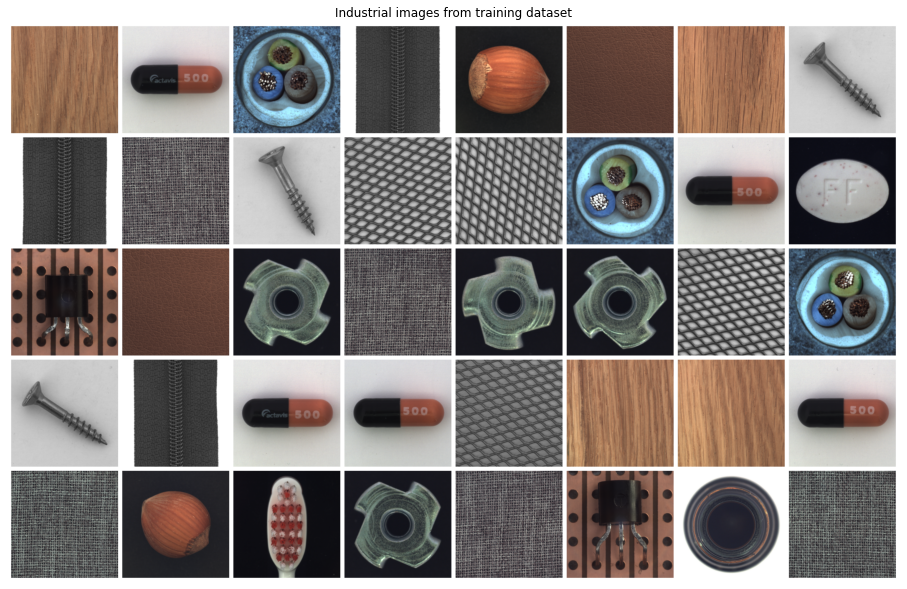

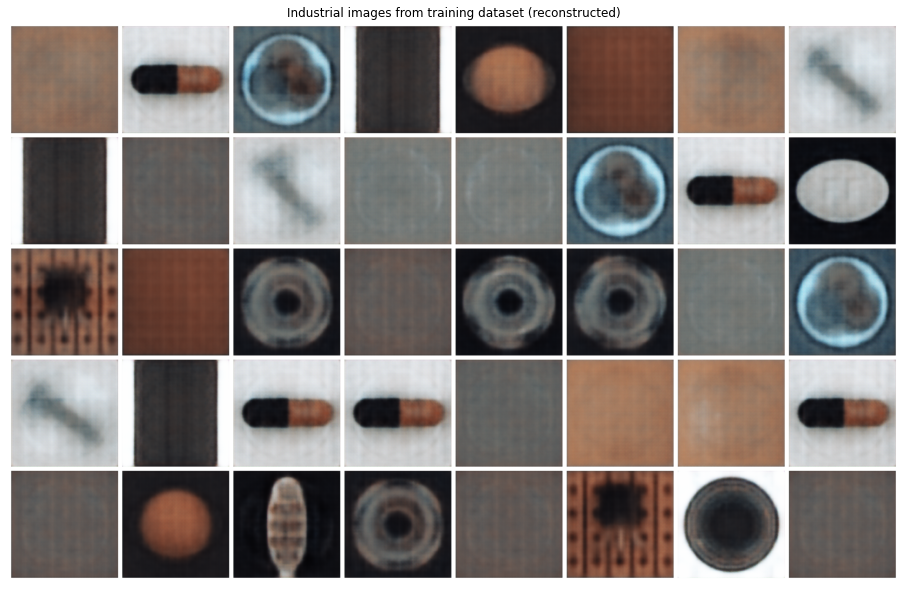

In [5]:
batch = iter(data.train_dataloader()).next()
plot_objects(MVTec_DataModule.denormalize(batch["img"][0:40]), images_per_row=8, title="Industrial images from training dataset")

batch_recon = model(batch["img"])
plot_objects(MVTec_DataModule.denormalize(batch_recon[0:40]), images_per_row=8, title="Industrial images from training dataset (reconstructed)")